In [1]:
# here you can place default parameters which will be overwritten by the 
# actual parameters in a new cell below
spatial_res = 0.00018
aoi = "POLYGON ((11.519165 41.786673, 11.519165 42.259016, 12.420044 42.259016, 12.420044 41.786673, 11.519165 41.786673))"

In [2]:
# Configure logging to stderr such that messages appear in notebook
# NOTE: Logging messages from python files which are called from the notebook 
#       will then also appear in the notebook.
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
)

In [3]:
from pathlib import Path

# This is a fixed path you can use to write the output file to.
# The data written here will end up in a unique location for every job run.
output_dir = Path("/home/jovyan/result-data")

In [4]:
import shapely.wkt

# aoi is passed as WKT, need bbox
polygon = shapely.wkt.loads(aoi)
bbox = polygon.bounds
bbox

(11.519165, 41.786673, 12.420044, 42.259016)

In [5]:
from datetime import date, timedelta
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
import xcube.core.maskset as maskset
import xarray as xr

# credentials from your EDC account are automatically available as environment variables
# which are then used by xcube_sh

date_today = date.today()
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'SCL'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=[(date_today - timedelta(days=10)).strftime("%Y-%m-%d"), (date_today - timedelta(days=1)).strftime("%Y-%m-%d")])

cube = open_cube(cube_config)

# print basic information here to help with debugging
water_cube = cube.where(maskset.MaskSet(cube.SCL).water)
water_cube

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 3072, lon: 5120, time: 3)
Coordinates:
  * lat        (lat) float64 42.34 42.34 42.34 42.34 ... 41.79 41.79 41.79 41.79
  * lon        (lon) float64 11.52 11.52 11.52 11.52 ... 12.44 12.44 12.44 12.44
  * time       (time) datetime64[ns] 2021-09-30T10:19:06 ... 2021-10-05T10:19:02
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-10-09T18:25:58.244808
    time_coverage_start:     2021-09-30T10:18:57+00:00
    time_coverage_end:       2021-10-05T10:19:12+00:00
    time_coverage_duration:  P5DT0H0M15S
    geospatial_lon_min:      11.519165
    geospatial_lat_min:      41.786673
    geospatial_lon_max:      12.440764999999999
    geospatial_lat_max:      42.339633
    processing_level:        L2A

In [6]:
b_from = water_cube.B04
b_peek = water_cube.B05
b_to = water_cube.B06

wlen_from = b_from.attrs['wavelength']
wlen_peek = b_peek.attrs['wavelength']
wlen_to = b_to.attrs['wavelength']

f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
mci = (b_peek - b_from) - f * (b_to - b_from)

mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
mci.attrs['units'] = 'unitless'
mci

<xarray.DataArray (time: 3, lat: 3072, lon: 5120)>
dask.array<sub, shape=(3, 3072, 5120), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 42.34 42.34 42.34 42.34 ... 41.79 41.79 41.79 41.79
  * lon      (lon) float64 11.52 11.52 11.52 11.52 ... 12.44 12.44 12.44 12.44
  * time     (time) datetime64[ns] 2021-09-30T10:19:06 ... 2021-10-05T10:19:02
Attributes:
    long_name:  Maximum Chlorophyll Index
    units:      unitless

In [7]:
result = xr.Dataset({'mci': mci}).mci.isel(time=-1)
logging.info("size: %s", result.size)

2021-10-09 18:25:58,794 [INFO] root - size: 15728640


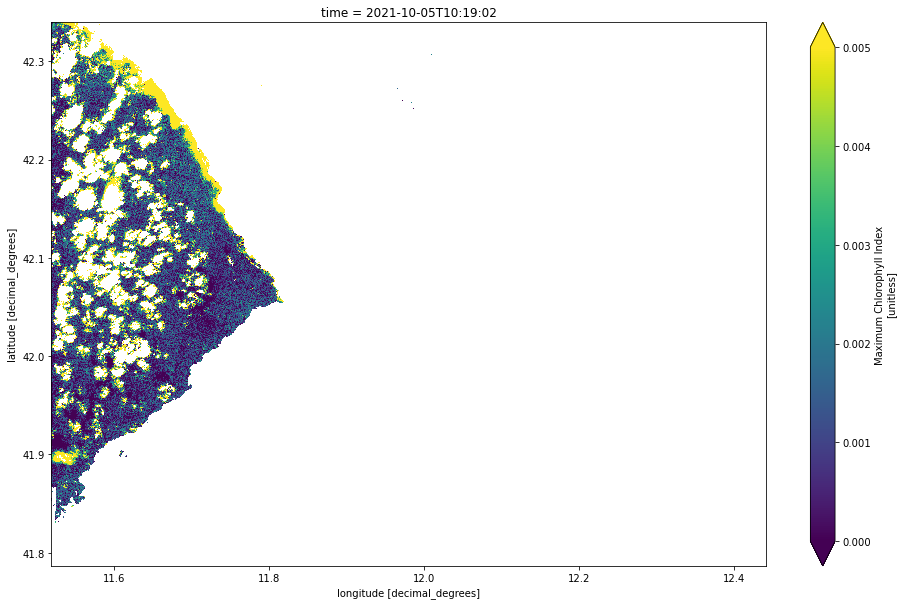

In [8]:
%matplotlib inline
import IPython.display
result.plot.imshow(vmin=0, vmax=0.005, cmap='viridis', figsize=(16, 10))

In [9]:
filename = date_today.strftime("%Y-%m-%d") + ".tif"
result.rio.to_raster(output_dir / filename, dtype="float32")
logging.info("file %s written", filename)

2021-10-09 18:26:40,198 [INFO] root - file 2021-10-09.tif written
